# Neural Networks : WS23/24 Project
## Introduction : The Acoustic Weld Inspection Project (AKoS)
- Submitted by Shashwat Pandey (spande2s), Talha Riyaz Shaikh (tshaik2s)


The Acoustic Weld Inspection Project (AKoS) enhances weld seam quality assurance for safety-critical components using innovative machine learning, particularly autoencoders. It addresses limitations in traditional methods like visual examination and ultrasonic testing. AKoS leverages acoustic data to develop a robust system for accurate anomaly detection in weld seams. It aims to develop a non-destructive testing (NDT) method for welding seams in safety-critical components.

## Solution Overview

The proposed solution leverages autoencoders, a type of neural network designed for unsupervised learning. Autoencoders consist of an encoder and a decoder, with the primary objective of learning a compressed representation of input data. In the context of AKoS, this compressed representation captures essential features of acoustic signals associated with normal weld seams
The proposed solution utilizes autoencoders, a neural network architecture tailored for unsupervised learning, to encapsulate crucial characteristics within acoustic signals associated with normal weld seams in AKoS. The workflow involves:

1. **Data Understanding:**
   - Analyzing the frequency representation of acoustic signals through Power and Mel spectrograms for only the files associated with "**Microphone Gefell 1 = MK301, Amplification "32**"

2. **Feature Extraction:**
   - Mel Spectrogram: A frequency-domain representation of the signal's spectrum, emphasizing the distribution of energy across different frequency bands.
   - Pore Amplitude Feature: Captures amplitude information within specified frequency ranges associated with pores or defects in weld seams.
   - Spectral Contrast Feature: Measures the difference in amplitude between peaks and valleys in the spectrum, with statistical descriptors (mean and standard deviation) computed for added context.

3. **Scaling and Feature Agglomeration Application:**
   - Applying scaling and feature agglomeration techniques to enhance data representation.

4. **Autoencoder Training (Normal Data - Non-Pore):**
   - Training the autoencoder on only the normal data to capture inherent patterns.

5. **Testing and Evaluation:**
   - Assessing the model's performance based on reconstruction errors.

6. **Classification Comparison:**
   - Comparing reconstruction errors for Pore and Non-Pore classification.

In [46]:
# IMPORTING LIBRARIES
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import librosa
from bitstring import ConstBitStream
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import FeatureAgglomeration
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import LearningRateScheduler
import pickle
from tensorflow.keras import layers, models
from scipy.signal import get_window
from librosa.display import specshow
from scipy.fft import fft
from scipy.signal import stft

# Save the requirements
with open('requirements.txt', 'w') as f:
    f.write('\n'.join(os.popen('pip freeze').read().split('\n')))

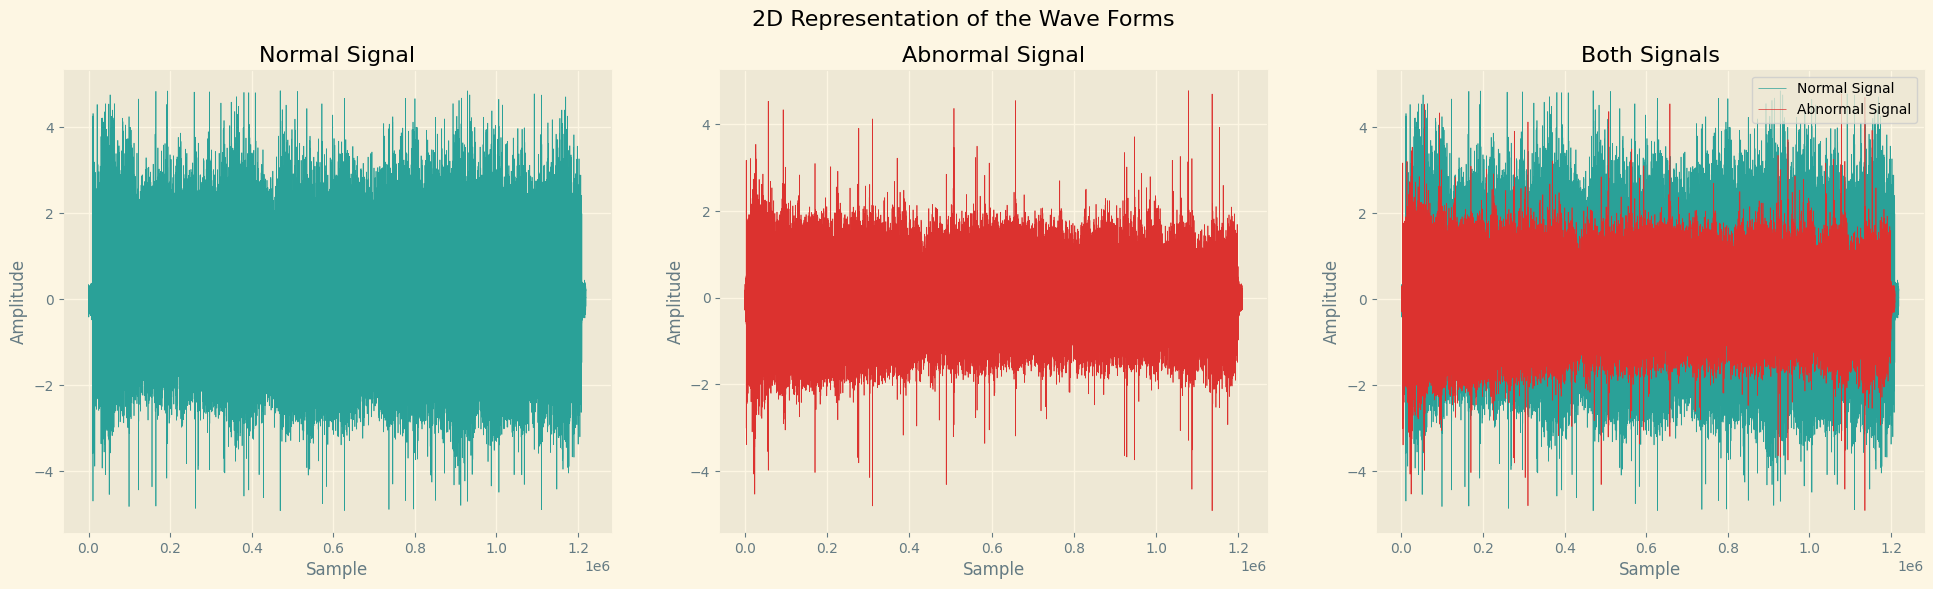

In [66]:
# Understanding the data as framed audio and STFT
def reading(filepath):
    with open(filepath, 'rb') as file:
        data = file.read()
        floararray = np.frombuffer(data, dtype=np.float32)
    return floararray

def normalize_audio(audio):
    return audio / np.max(np.abs(audio))

def load_sound_file(path):
    signal = reading(path)
    sr = 96000  # Update this with the actual sample rate of your audio files
    return signal, sr

def frame_audio_stft(audio, FFT_size=1024, hop_size=512, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num, FFT_size), dtype=np.float32)
    
    for n in range(frame_num):
        frames[n] = audio[n * frame_len:n * frame_len + FFT_size]
    
    _, _, Zxx = stft(frames, fs=sample_rate, nperseg=FFT_size)
    
    return frames, Zxx  # Return the framed audio and the STFT result

normal_file_path = "./Project_Files/normal/L08_09-59-44_io-pass/MikroGefell1_96khz_float32_09-59-44.I32"
abnormal_file_path = "./Project_Files/Test_data/L24_10-34-35_no-oel_nio-oel-fail-AL_OEL/MikroGefell1_96khz_float32_10-34-35.I32"


normal_signal, normal_sr = load_sound_file(normal_file_path)
abnormal_signal, abnormal_sr = load_sound_file(abnormal_file_path)

# Use the same parameters as in your original code
FFT_size = 1024
hop_size = 512
sample_rate = 96000

# Frame and calculate STFT for normal and abnormal signals
normal_frames, normal_stft = frame_audio_stft(normal_signal, FFT_size, hop_size, normal_sr)
abnormal_frames, abnormal_stft = frame_audio_stft(abnormal_signal, FFT_size, hop_size, abnormal_sr)

plt.style.use("Solarize_Light2")
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]# Plot the waveforms
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Normal Signal
axes[0].set_title("Normal Signal")
axes[0].plot(normal_signal, color=colors[1], linewidth=0.5)
axes[0].set_xlabel("Sample")
axes[0].set_ylabel("Amplitude")

# Abnormal Signal
axes[1].set_title("Abnormal Signal")
axes[1].plot(abnormal_signal, color=colors[5], linewidth=0.5)
axes[1].set_xlabel("Sample")
axes[1].set_ylabel("Amplitude")

# Both Signals
axes[2].set_title("Both Signals")
axes[2].plot(normal_signal, color=colors[1], linewidth=0.5, label="Normal Signal")
axes[2].plot(abnormal_signal, color=colors[5], linewidth=0.5, label="Abnormal Signal")
axes[2].set_xlabel("Sample")
axes[2].set_ylabel("Amplitude")

# Specify legend location
axes[2].legend(loc="upper right")

# Save the figure
fig.suptitle("2D Representation of the Wave Forms", fontsize=16)
plt.show()


##  Fourier Transforms in Acoustic Weld Inspection

Fourier transforms play a crucial role in the Acoustic Weld Inspection Project (AKoS) by providing a frequency-domain representation of acoustic signals. This section explores the theoretical foundation of Fourier transforms, their relevance in signal processing, and their specific application in the project.
###  Role in Feature Extraction

In the provided code for AKoS, Fourier transforms are employed to extract relevant features from acoustic signals. Specifically, the Short-Time Fourier Transform (STFT) is utilized to compute the mel spectrogram, a critical component in characterizing the frequency content of the acoustic data.

### Short-Time Fourier Transform (STFT)

The STFT is a time-dependent extension of the Fourier transform, designed to capture variations in frequency content over short time intervals. It is a technique used to analyze the frequency content of a signal over short, overlapping time intervals. It provides a time-dependent representation of the signal's frequency components. The STFT is computed by dividing the signal into small, overlapping segments and applying the Fourier transform to each segment.

In the provided code:
- `n_fft` is the number of points used in each Fourier transform.
- `hop_length` determines the number of samples between successive STFT columns, creating overlapping windows.
- `librosa.stft` computes the STFT of the given signals (`normal_signal` and `abnormal_signal`).
- The resulting STFTs (`normal_stft` and `abnormal_stft`) represent the magnitude of the signal's frequency components for short time intervals.

In the AKoS project, the mel spectrogram is computed using the librosa library, providing a visual representation of the frequency content of the acoustic signals over time.


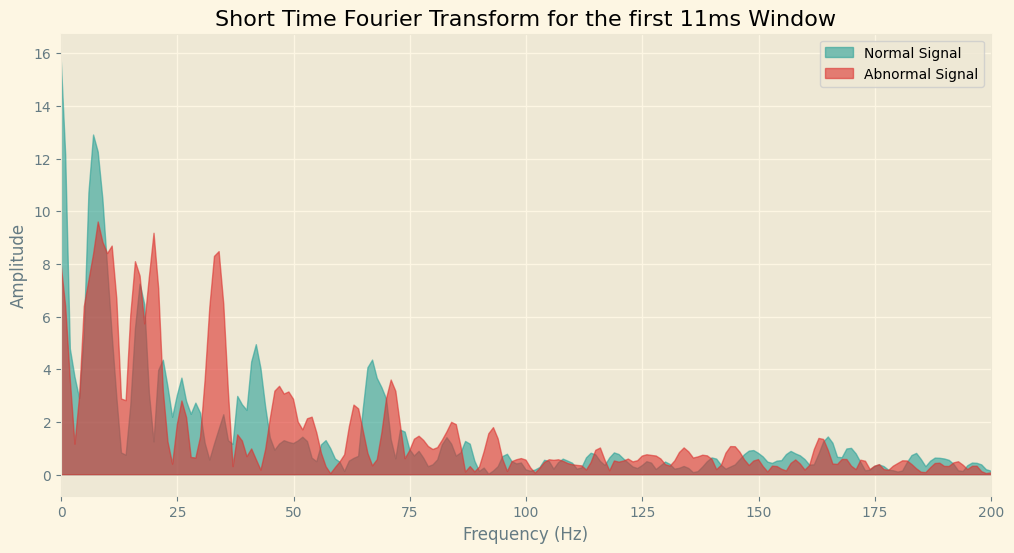

In [67]:
# Short-Time Fourier Transform
n_fft = 1024
hop_length = n_fft + 1
normal_stft = np.abs(librosa.stft(normal_signal[:n_fft], n_fft=n_fft, hop_length=hop_length))
abnormal_stft = np.abs(librosa.stft(abnormal_signal[:n_fft], n_fft=n_fft, hop_length=hop_length))

fig, ax = plt.subplots(figsize=(12, 6))

# Filled area plot for Normal Signal
ax.fill_between(np.arange(len(normal_stft)), 0, normal_stft.flatten(), color=colors[1], alpha=0.6, label="Normal Signal")

# Filled area plot for Abnormal Signal
ax.fill_between(np.arange(len(abnormal_stft)), 0, abnormal_stft.flatten(), color=colors[5], alpha=0.6, label="Abnormal Signal")

ax.set_title(f"Short Time Fourier Transform for the first {n_fft / normal_sr * 1000:.0f}ms Window")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Amplitude")
ax.legend()
ax.set_xlim(0, 200)

plt.show()

### Fourier Transforms in Feature Extraction

The following excerpt from the provided code illustrates the use of Fourier transforms in the feature extraction process:

```python
# Mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(
    y=signal,
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels
)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
```

Here, the `librosa.feature.melspectrogram` function computes the mel spectrogram, and `librosa.power_to_db` converts it to a logarithmic scale for improved representation of perceptual loudness.

### Mel Spectrogram:

The Mel spectrogram is a crucial feature that provides a frequency-domain representation of the signal's spectrum. It emphasizes the distribution of energy across different frequency bands, offering insights into the acoustic characteristics of weld seams.

Additionally, Fourier transforms contribute to the computation of the pore amplitude feature:

```python
# Pore amplitude feature
pore_amplitude = np.mean(np.abs(librosa.core.stft(signal, n_fft=n_fft, hop_length=hop_length)[pore_frequency_range[0]//10:pore_frequency_range[1]//10, :]), axis=0)
```

Here, the Short-Time Fourier Transform (STFT) is applied to extract the amplitude information within the specified frequency range associated with pores.

1. **Normal Signal Power Spectrogram:**
   - **Short-Time Fourier Transform (STFT):** Converts the normal acoustic signal into its frequency representation by dividing it into short time intervals.
   - **Power Spectrogram:** Squares the magnitudes of the STFT, representing the signal's power distribution over time and frequency.
   - **Decibel Scaling:** Converts the power spectrogram to a logarithmic scale for better visualization and emphasis on perceptually relevant features.

2. **Normal Signal Mel Spectrogram:**
   - **Mel Spectrogram:** Utilizes the mel-frequency cepstral coefficients (MFCCs) to represent the normal signal's frequency content.
   - **Decibel Scaling:** Converts the mel spectrogram to a logarithmic scale for improved representation and feature extraction.

3. **Abnormal Signal Power Spectrogram and Mel Spectrogram:**
   - Similar steps are applied to the abnormal acoustic signal, providing comparable visualizations of power and mel spectrograms.

**Significance**:

Similar steps are applied to the abnormal acoustic signal, providing comparable visualizations of power and mel spectrograms.
Enables the comparison of acoustic characteristics between normal and abnormal signals, with decibel scaling enhancing visibility and emphasizing relevant features in the frequency domain

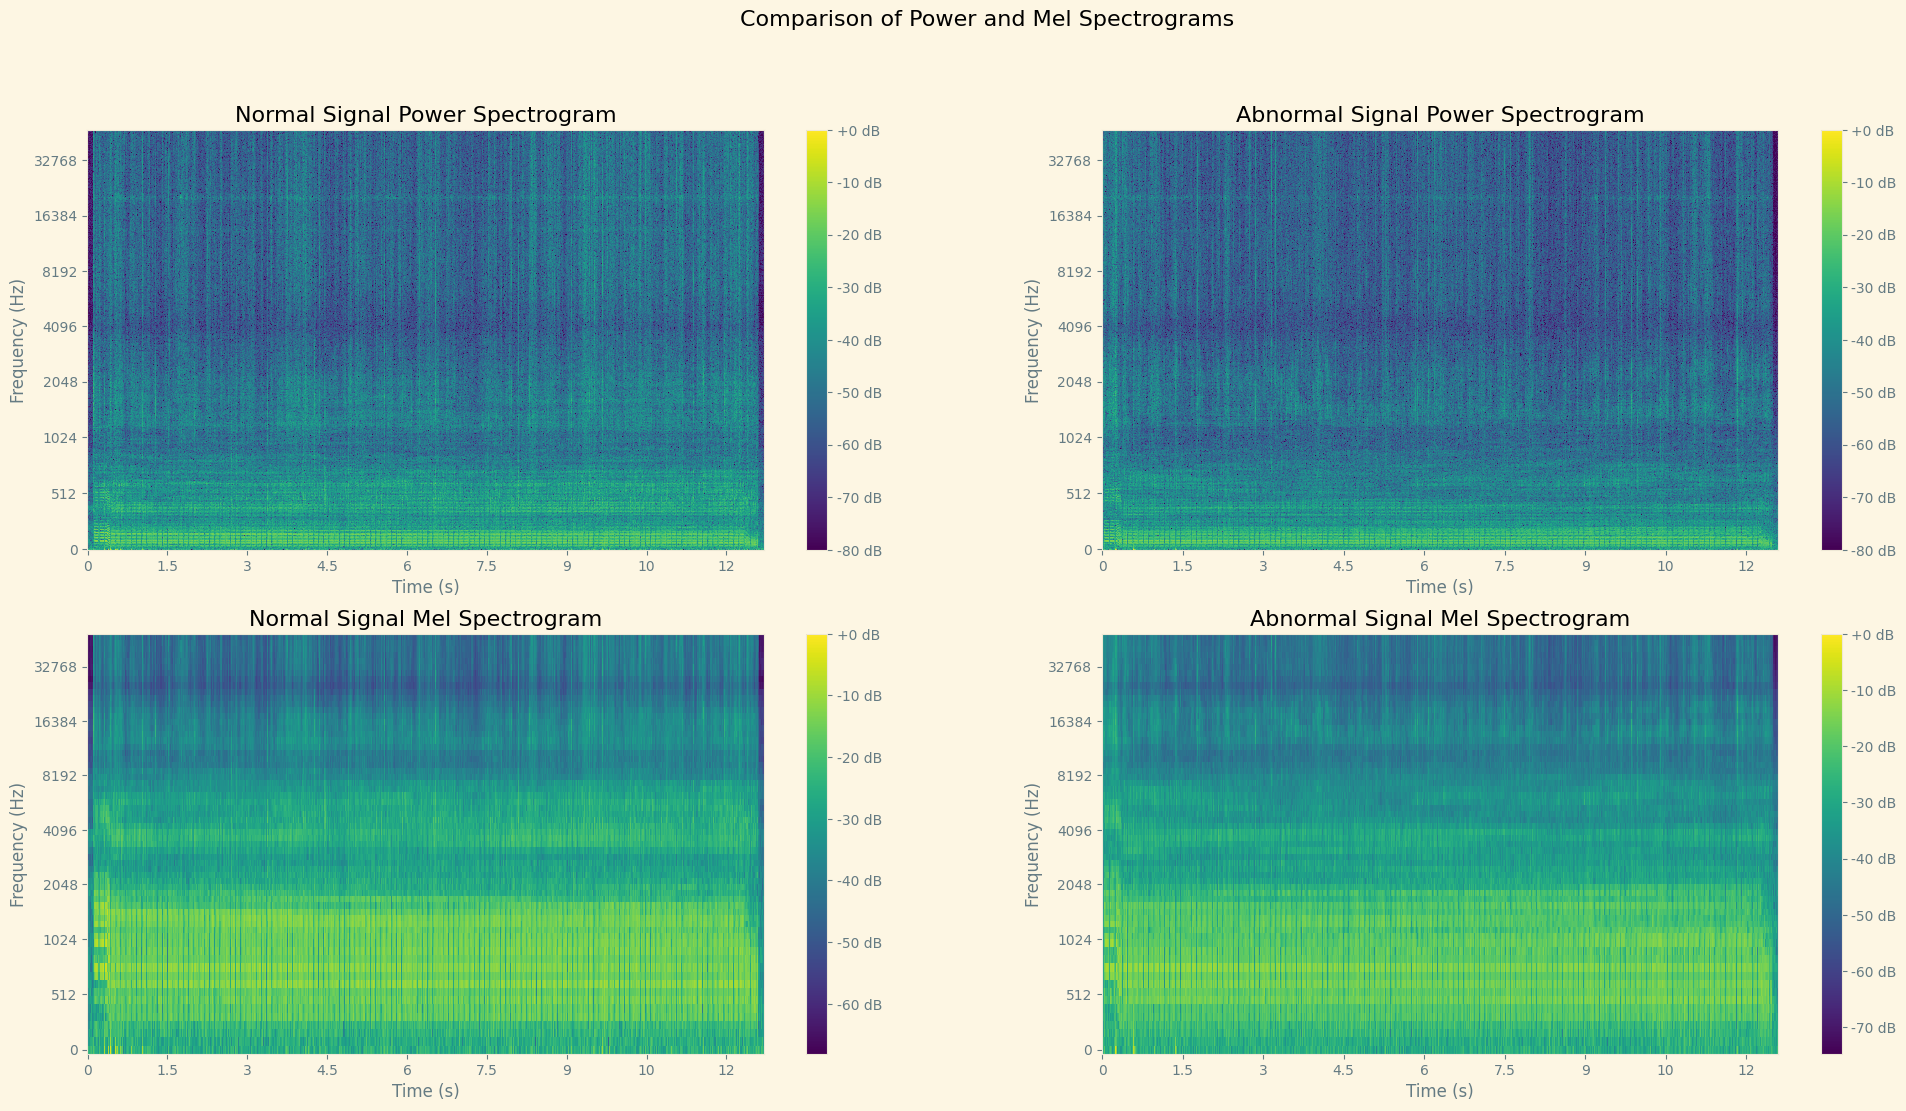

In [68]:
# Comparison of Power and Mel Spectrograms
# Parameters
n_fft = 2048
hop_length = 512
n_mels = 64

# Normal Signal
normal_stft = np.abs(librosa.stft(normal_signal, n_fft=n_fft, hop_length=hop_length))
normal_power_spectrogram = normal_stft ** 2  # Calculate power
normal_spectrogram = librosa.power_to_db(normal_power_spectrogram, ref=np.max)

S_normal = librosa.feature.melspectrogram(
    y=normal_signal, sr=normal_sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
)
normal_mel_spectrogram = librosa.power_to_db(S_normal, ref=np.max)

# Abnormal Signal
abnormal_stft = np.abs(librosa.stft(abnormal_signal, n_fft=n_fft, hop_length=hop_length))
abnormal_power_spectrogram = abnormal_stft ** 2  # Calculate power
abnormal_spectrogram = librosa.power_to_db(abnormal_power_spectrogram, ref=np.max)

S_abnormal = librosa.feature.melspectrogram(
    y=abnormal_signal, sr=abnormal_sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
)
abnormal_mel_spectrogram = librosa.power_to_db(S_abnormal, ref=np.max)

# Plot Power Spectrograms
fig, axes = plt.subplots(2, 2, figsize=(24, 12))

# Normal Signal Power Spectrogram
axes[0, 0].set_title("Normal Signal Power Spectrogram")
librosa.display.specshow(
    normal_spectrogram, sr=normal_sr, x_axis="time", y_axis="mel", cmap="viridis", ax=axes[0, 0]
)
axes[0, 0].set_xlabel("Time (s)")
axes[0, 0].set_ylabel("Frequency (Hz)")
fig.colorbar(format="%+2.0f dB", mappable=axes[0, 0].collections[0], ax=axes[0, 0])

# Abnormal Signal Power Spectrogram
axes[0, 1].set_title("Abnormal Signal Power Spectrogram")
librosa.display.specshow(
    abnormal_spectrogram, sr=abnormal_sr, x_axis="time", y_axis="mel", cmap="viridis", ax=axes[0, 1]
)
axes[0, 1].set_xlabel("Time (s)")
axes[0, 1].set_ylabel("Frequency (Hz)")
fig.colorbar(format="%+2.0f dB", mappable=axes[0, 1].collections[0], ax=axes[0, 1])

# Normal Signal Mel Spectrogram
axes[1, 0].set_title("Normal Signal Mel Spectrogram")
librosa.display.specshow(
    normal_mel_spectrogram, sr=normal_sr, hop_length=hop_length, x_axis="time", y_axis="mel", cmap="viridis", ax=axes[1, 0]
)
axes[1, 0].set_xlabel("Time (s)")
axes[1, 0].set_ylabel("Frequency (Hz)")
fig.colorbar(format="%+2.0f dB", mappable=axes[1, 0].collections[0], ax=axes[1, 0])

# Abnormal Signal Mel Spectrogram
axes[1, 1].set_title("Abnormal Signal Mel Spectrogram")
librosa.display.specshow(
    abnormal_mel_spectrogram, sr=abnormal_sr, hop_length=hop_length, x_axis="time", y_axis="mel", cmap="viridis", ax=axes[1, 1]
)
axes[1, 1].set_xlabel("Time (s)")
axes[1, 1].set_ylabel("Frequency (Hz)")
fig.colorbar(format="%+2.0f dB", mappable=axes[1, 1].collections[0], ax=axes[1, 1])

fig.suptitle("Comparison of Power and Mel Spectrograms", fontsize=16)
plt.show()

### Data Processing and Feature Extraction

This section outlines the data processing and feature extraction pipeline implemented in the Acoustic Weld Inspection Project (AKoS). The provided code encompasses various functions and libraries for reading, processing, and extracting features from raw acoustic data.
1. **Reading Raw Acoustic Data**

The read_i32 function serves as the initial step in the data processing pipeline. This function reads binary data from a specified file, assuming a 96 kHz sample rate, and converts it into a usable format. The resulting array, data_array, represents the raw acoustic signal. We are only concerned with the audio files associated with "**Microphone Gefell 1 = MK301, Amplification "32**" for the purpose of this investigation


2. **Feature Extraction**

The core of the feature extraction process lies in the feature_extraction function. This function utilizes several signal processing techniques to derive informative features from the acoustic signal. The features include:

- Mel Spectrogram: Computes mel spectrogram and converts to a decibel scale

- Pore Amplitude: Calculates mean absolute value of STFT within a specific frequency range

- Spectral Contrast: Computes spectral contrast feature

- Statistical Descriptors: Computes mean and standard deviation for spectral contrast

- Feature Vector: Combines mel spectrogram, pore amplitude, and statistical descriptors

- Length Adjustment: Zero-pads or truncates feature vectors for consistent length

- Output: Returns a matrix with the extracted features
   


# Preprocessing Functions to be run before testing

In [53]:
# Preprocessing functions
sample_rate=96000

def read_i32(filepath):
    with open(filepath, 'rb') as file:
        data = file.read()
        sample_rate = 96000
        float_array = np.frombuffer(data, dtype=np.float32)
    return np.array(float_array), sample_rate

def feature_extraction(signal, sr, n_fft=2048, hop_length=512, n_mels=64, frames=15, pore_frequency_range=(500, 2000), max_feature_length=3069):
    # Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(
        y=signal,
        sr=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Pore amplitude feature
    pore_amplitude = np.mean(np.abs(librosa.core.stft(signal, n_fft=n_fft, hop_length=hop_length)[pore_frequency_range[0]//10:pore_frequency_range[1]//10, :]), axis=0)

    # Spectral contrast feature
    spectral_contrast = librosa.feature.spectral_contrast(y=signal, sr=sample_rate, hop_length=hop_length)

    # Statistical descriptors for spectral contrast
    mean_spectral_contrast = np.mean(spectral_contrast, axis=0)
    std_spectral_contrast = np.std(spectral_contrast, axis=0)

    # Combine existing and additional features
    features_vector_size = log_mel_spectrogram.shape[1] - frames + 1
    dims = frames * n_mels + 3  # 1 for pore amplitude, 2 for mean and std of spectral contrast

    if features_vector_size < 1:
        return np.empty((0, dims), np.float32)

    features = np.zeros((features_vector_size, dims), np.float32)

    for t in range(frames):
        features[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t:t + features_vector_size].T

    # Insert the pore amplitude feature
    features[:, -3] = pore_amplitude[:features_vector_size]

    # Insert mean and std of spectral contrast
    features[:, -2] = mean_spectral_contrast[:features_vector_size]
    features[:, -1] = std_spectral_contrast[:features_vector_size]

    # Zero-pad or truncate the feature vectors to a consistent length
    if features.shape[0] < max_feature_length:
        padded_features = np.zeros((max_feature_length, dims), dtype=features.dtype)
        padded_features[:features_vector_size, :] = features
        features = padded_features
    elif features.shape[0] > max_feature_length:
        features = features[:max_feature_length, :]

    return features

# Function to process files and extract features
def process_files(directory):
    feature_dataset = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if "MikroGefell1_96khz" in file:
                file_path = os.path.join(root, file)
                data_array, sample_rate = read_i32(file_path)
                # Extract features using the provided function
                features= feature_extraction(data_array, sample_rate)
                feature_dataset.append(features)

    # Convert the list of arrays into a 2D array
    feature_dataset = np.vstack(feature_dataset)
    return feature_dataset


## Loading Train and Test data
#### Train_Data : Wall_17_AL_io_20220614 (Non-Pore)
#### Test_Data : Wall_23_AL_Oel_Zusatz_20220620 (Pore)

In [15]:
# # Directory to load data from
# normal_directory_path = "./Project_Files/Dataset/npore/"
# ---------- ----------Add Wall_17_AL_io_20220614 to the normal directory npore

# abnormal_directory_path = "./Project_Files/Dataset/pore/"
# ---------- ----------Add Wall_23_AL_Oel_Zusatz_20220620 to the abnormal directory pore

# # Process files to get feature dataset
# train_data= process_files(normal_directory_path)
# test_data= process_files(abnormal_directory_path)


In [16]:
# # Define the file path to save data as a pickle
# train_pickle = "./Project_Files/Dataset/train_no_pore_96khz.pkl"
# test_pickle = "./Project_Files/Dataset/test_pore_96khz.pkl"

# # Save the train_data as a pickle file
# with open(train_pickle, 'wb') as file:
#     pickle.dump(train_data, file)
# with open(test_pickle, 'wb') as file: 
#     pickle.dump(test_data, file)


In [44]:
# # Read the saved data to apply preprocessing
# train_pickle = "./Project_Files/Dataset/train_no_pore_96khz.pkl"
# test_pickle = "./Project_Files/Dataset/test_pore_96khz.pkl"

# with open(train_pickle, 'rb') as file:
#     train_data = pickle.load(file)

# with open(test_pickle, 'rb') as file:
#     test_data = pickle.load(file)

##  Feature Visualization

This section demonstrates the visualization of key features extracted from acoustic signals in the Acoustic Weld Inspection Project (AKoS). The code provided utilizes matplotlib and librosa libraries to create visual representations of Mel spectrograms, Pore Amplitude Features, and Spectral Contrast Features for both training and test signals.

###  Mel Spectrograms

The Mel spectrogram is a crucial feature that provides a frequency-domain representation of the signal's spectrum. It emphasizes the distribution of energy across different frequency bands, offering insights into the acoustic characteristics of weld seams.

```python
# Plot Mel spectrogram for the training signal
mel_spectrogram_train = librosa.feature.melspectrogram(y=train_signal, sr=sample_rate, n_mels=n_mels)
log_mel_spectrogram_train = librosa.power_to_db(mel_spectrogram_train, ref=np.max)
librosa.display.specshow(log_mel_spectrogram_train, cmap='viridis', x_axis='time', y_axis='mel', ax=axes[0, 0])
axes[0, 0].set_title("Train Signal Mel Spectrogram")

# Plot Mel spectrogram for the test signal
mel_spectrogram_test = librosa.feature.melspectrogram(y=test_signal, sr=sample_rate, n_mels=n_mels)
log_mel_spectrogram_test = librosa.power_to_db(mel_spectrogram_test, ref=np.max)
librosa.display.specshow(log_mel_spectrogram_test, cmap='viridis', x_axis='time', y_axis='mel', ax=axes[0, 1])
axes[0, 1].set_title("Test Signal Mel Spectrogram")
```
These visualizations offer a qualitative understanding of the frequency content of both training and test signals.

These plots visualize the amplitude variations within the specified frequency ranges, aiding in the identification of anomalies or defects.

###  Spectral Contrast Features

Spectral Contrast Features measure the difference in amplitude between peaks and valleys in the spectrum. The code visualizes these features for both training and test signals.

```python
# Plot Spectral Contrast Features for the training signal
axes[1, 0].imshow(train_data[0, :-3].reshape(frames, n_mels).T, aspect='auto', cmap='viridis', extent=[0, frames, 0, n_mels])
axes[1, 0].set_title("Train Signal Spectral Contrast Features")

# Plot Spectral Contrast Features for the test signal
axes[1, 1].imshow(test_data[0, :-3].reshape(frames, n_mels).T, aspect='auto', cmap='viridis', extent=[0, frames, 0, n_mels])
axes[1, 1].set_title("Test Signal Spectral Contrast Features")
```

These visualizations provide insights into the amplitude variations across different frequency bands, aiding in the detection of distinctive patterns associated with anomalies.

This feature visualization section enhances the interpretability of the extracted features and provides a qualitative assessment of the acoustic characteristics associated with weld seams.

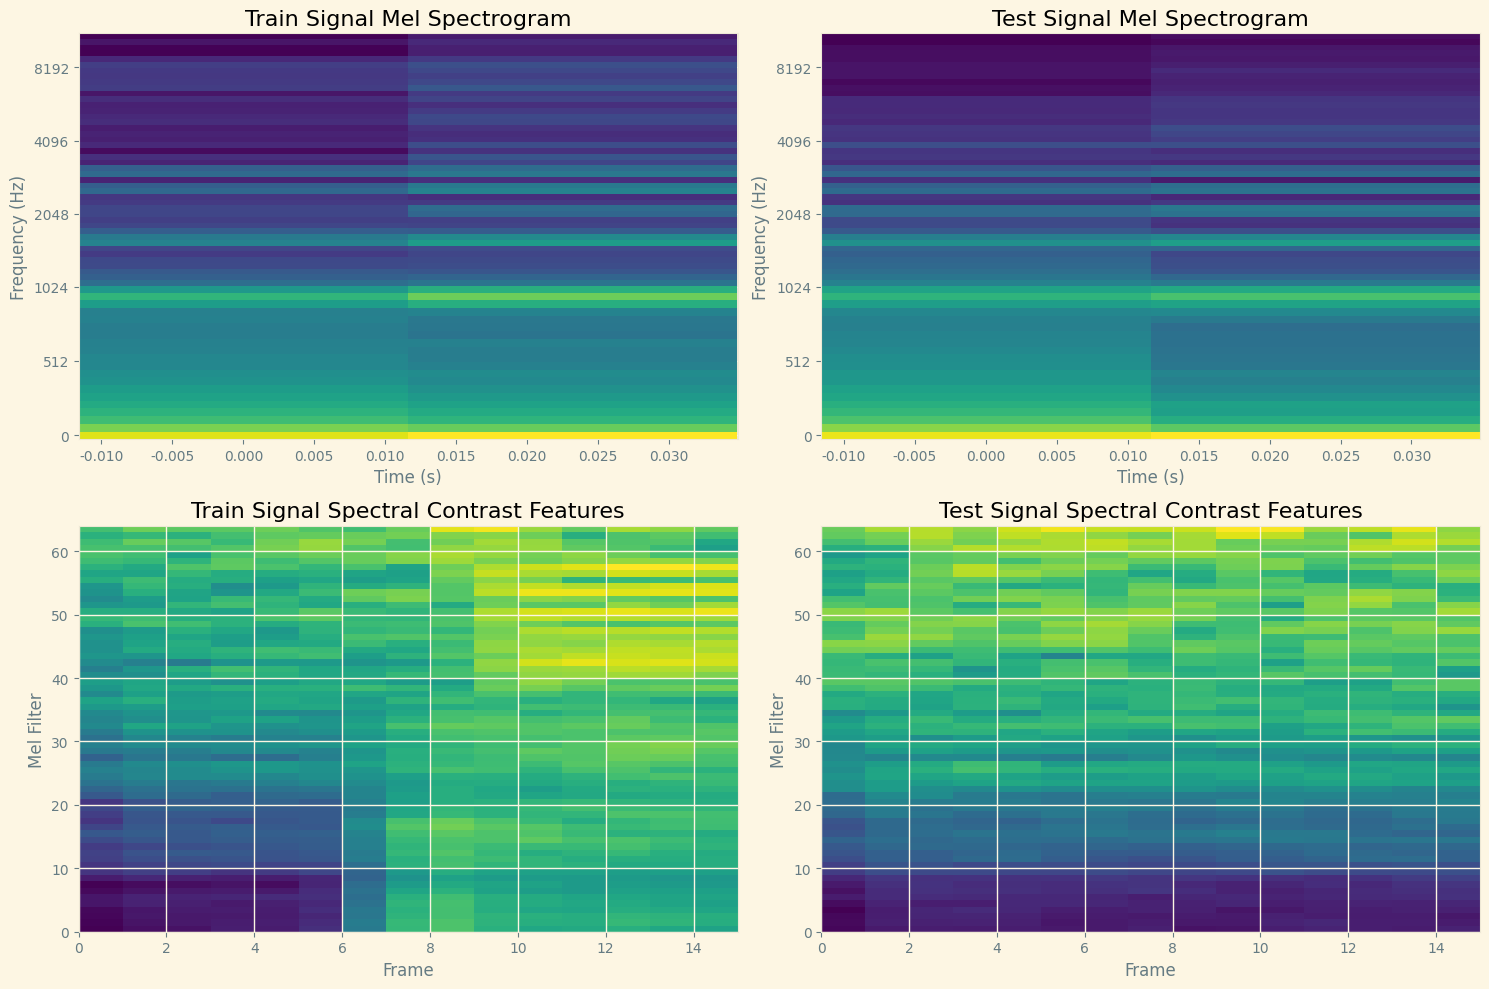

In [49]:
# Function to plot Mel Spectogram and Constrast Feature
import matplotlib.pyplot as plt
import librosa.display

# Example signals (replace with your actual signals)
train_signal = train_data[10, :-3]  
test_signal = test_data[10, :-3]  

# Parameters for feature extraction (replace with your actual parameters)
sample_rate = 96000
n_mels = 64
frames = 15
# Plot the features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot Mel spectrogram for the training signal
mel_spectrogram_train = librosa.feature.melspectrogram(y=train_signal, sr=sample_rate, n_mels=n_mels)
log_mel_spectrogram_train = librosa.power_to_db(mel_spectrogram_train, ref=np.max)
librosa.display.specshow(log_mel_spectrogram_train, cmap='viridis', x_axis='time', y_axis='mel', ax=axes[0, 0])
axes[0, 0].set_title("Train Signal Mel Spectrogram")
axes[0, 0].set_xlabel("Time (s)")
axes[0, 0].set_ylabel("Frequency (Hz)")

# Plot Mel spectrogram for the test signal
mel_spectrogram_test = librosa.feature.melspectrogram(y=test_signal, sr=sample_rate, n_mels=n_mels)
log_mel_spectrogram_test = librosa.power_to_db(mel_spectrogram_test, ref=np.max)
librosa.display.specshow(log_mel_spectrogram_test, cmap='viridis', x_axis='time', y_axis='mel', ax=axes[0, 1])
axes[0, 1].set_title("Test Signal Mel Spectrogram")
axes[0, 1].set_xlabel("Time (s)")
axes[0, 1].set_ylabel("Frequency (Hz)")

# Plot Spectral Contrast Features for the training signal
axes[1, 0].imshow(train_data[0, :-3].reshape(frames, n_mels).T, aspect='auto', cmap='viridis', extent=[0, frames, 0, n_mels])
axes[1, 0].set_title("Train Signal Spectral Contrast Features")
axes[1, 0].set_xlabel("Frame")
axes[1, 0].set_ylabel("Mel Filter")

# Plot Spectral Contrast Features for the test signal
axes[1, 1].imshow(test_data[0, :-3].reshape(frames, n_mels).T, aspect='auto', cmap='viridis', extent=[0, frames, 0, n_mels])
axes[1, 1].set_title("Test Signal Spectral Contrast Features")
axes[1, 1].set_xlabel("Frame")
axes[1, 1].set_ylabel("Mel Filter")

# Adjust layout
plt.tight_layout()
plt.show()


###  Pore Amplitude Features

The Pore Amplitude Feature captures amplitude information within specified frequency ranges associated with pores or defects in weld seams. This feature is visualized for both training and test signals.

```python
# Plot Pore Amplitude Feature for the training signal
axes[0, 2].plot(train_data[10, -3], label="Train Signal")
axes[0, 2].set_title("Train Signal Pore Amplitude Feature")
axes[0, 2].legend()

# Plot Pore Amplitude Feature for the test signal
axes[1, 2].plot(test_data[10, -3], label="Test Signal")
axes[1, 2].set_title("Test Signal Pore Amplitude Feature")
axes[1, 2].legend()
```
### Pore Amplitude Feature and Signal Visualization

The Pore Amplitude Feature is a critical aspect of the Acoustic Weld Inspection Project (AKoS), providing insights into characteristics associated with pores or defects in weld seams. This section discusses the theoretical foundation of the Pore Amplitude Feature and includes visualizations of the feature for both training and test signals.

### Theoretical Overview of Pore Amplitude Feature

The Pore Amplitude Feature is computed through the Short-Time Fourier Transform (STFT), a technique that reveals the amplitude information within specified frequency ranges associated with pores or defects in weld seams. In the context of AKoS, the Pore Amplitude Feature becomes a valuable descriptor for identifying anomalies in acoustic signals.


/home/shaxpy/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=963
  warnings.warn(


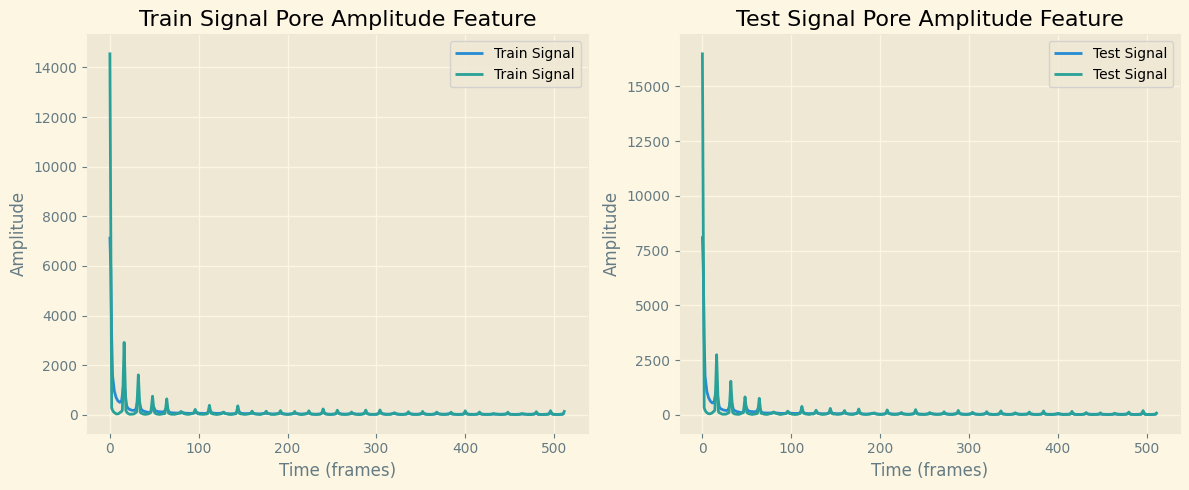

In [50]:
# Plotting Pore Amplitude Feature
import matplotlib.pyplot as plt
import librosa.display

# Function to calculate Pore Amplitude Feature
def pore_amplitude_feature(signal, pore_frequency_range=(500, 2000), sample_rate=96000, n_fft=1024, hop_length=512):
    stft_result = librosa.core.stft(signal, n_fft=n_fft, hop_length=hop_length)
    pore_amplitude = np.mean(np.abs(stft_result[pore_frequency_range[0]//10:pore_frequency_range[1]//10, :]), axis=0)
    return pore_amplitude

# Example signals (replace with your actual signals)
train_signal = train_data  
test_signal = test_data 

# Calculate Pore Amplitude Feature for the training signal
pore_amplitude_train = pore_amplitude_feature(train_signal)
# Calculate Pore Amplitude Feature for the test signal
pore_amplitude_test = pore_amplitude_feature(test_signal)

# Plot the features
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Pore Amplitude Feature for the training signal
axes[0].plot(pore_amplitude_train, label="Train Signal")
axes[0].set_title("Train Signal Pore Amplitude Feature")
axes[0].set_xlabel("Time (frames)")  # X-axis label
axes[0].set_ylabel("Amplitude")  # Y-axis label
axes[0].legend()

# Plot Pore Amplitude Feature for the test signal
axes[1].plot(pore_amplitude_test, label="Test Signal")
axes[1].set_title("Test Signal Pore Amplitude Feature")
axes[1].set_xlabel("Time (frames)")  # X-axis label
axes[1].set_ylabel("Amplitude")  # Y-axis label
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


## Display the features

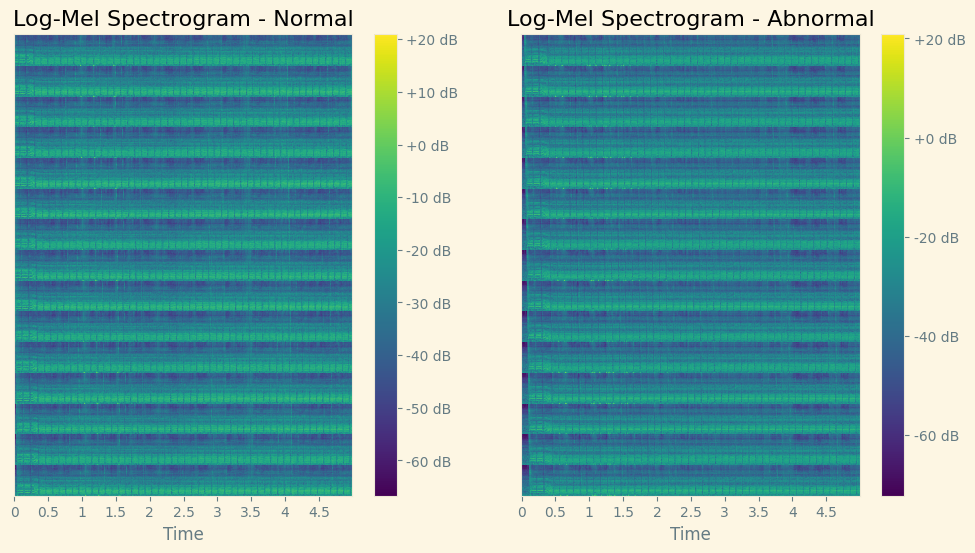

(153450, 963)
(156519, 963)


In [52]:
# # Display the shape of the train_data and test_data after feature extraction
# plt.figure(figsize=(12, 6))
# sample_rate=96000
# # Plot the first subplot with the initial part of train_data
# plt.subplot(1, 2, 1)
# librosa.display.specshow(train_data.T[:, :int(5 * sample_rate / 512)], x_axis='time', sr=sample_rate, hop_length=512, cmap='viridis')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Log-Mel Spectrogram - Normal')

# # Plot the second subplot with the initial part of test_data
# plt.subplot(1, 2, 2)
# librosa.display.specshow(test_data.T[:, :int(5 * sample_rate / 512)], x_axis='time', sr=sample_rate, hop_length=512, cmap='viridis')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Log-Mel Spectrogram - Abnormal')
# plt.show()
# print(train_data.shape)
# print(test_data.shape)

The first dimension (153450) refers to the number of samples or instances in your dataset. Each row in the matrix corresponds to a separate sample.

The second dimension (963) represents the number of features for each sample. Each column in the matrix corresponds to a feature.



## Scaling and Feature Agglomeration

### Feature Agglomeration:

Purpose: Feature agglomeration is a technique used for clustering similar features together into groups. The idea is to reduce the dimensionality of the dataset by representing each group of features with a single aggregated feature.
Operation: Features are grouped into clusters, and for each cluster, a representative feature (e.g., the mean or median of the features in the cluster) is computed. The dataset is then transformed to contain these representative features. The number of clusters determines the reduced dimensionality.'

### Why not Variance Thresholding?

Purpose: Variance thresholding removes features with low variance, indicating limited information content. It doesn't solve my purpose of generalizing the patterns in the data and capturing relationships amongst features
Operation: For each feature, variance is calculated, and features below a threshold are removed. Useful for eliminating constant or near-constant features.

### Why not PCA or KPCA?
Feature Agglomeration, Principal Component Analysis (PCA), and Kernel PCA (KPCA) are all dimensionality reduction techniques, each with unique approaches and implications for anomaly detection.

1. **Feature Agglomeration:**
   - **Approach:** Feature agglomeration clusters similar features together, creating new features that represent groups of the original features.
   - **Information Retention:** It retains the original features but in a clustered representation, where each feature represents a group of similar features.
   - **Flexibility:** Feature agglomeration can capture non-linear relationships by grouping similar features, offering flexibility in data representation.

2. **Principal Component Analysis (PCA):**
   - **Approach:** PCA finds orthogonal axes (principal components) that capture maximum variance in the data.
   - **Information Retention:** It creates new uncorrelated variables (principal components) that may not directly correspond to the original features.
   - **Linearity:** PCA is a linear technique and may not effectively capture non-linear relationships in the data.

3. **Kernel PCA (KPCA):**
   - **Approach:** KPCA extends PCA to capture non-linear relationships by using kernel functions to map the data into a higher-dimensional space.
   - **Computational Complexity:** KPCA can be computationally expensive, especially for large datasets, due to the computation of kernel matrices.
   - **Interpretability:** KPCA may produce less interpretable features compared to PCA or feature agglomeration.

**Key Differences:**
   - **Representation:** Feature agglomeration retains original features but clusters them, PCA creates new uncorrelated variables, and KPCA transforms data into a higher-dimensional space.
   - **Dimensionality Reduction:** PCA and feature agglomeration reduce dimensionality by creating fewer features or clusters, while KPCA captures non-linear relationships in the data through kernel transformations.
   - **Flexibility:** Feature agglomeration offers flexibility in capturing non-linear relationships by grouping similar features, while PCA and KPCA are limited by their linearity or kernel choices.



In [17]:
# Define feature agglomeration and scaling function 
def preprocess_data(train_data, test_data, n_clusters):
    # Adjust the number of clusters based on your requirements
    selector = FeatureAgglomeration(n_clusters=n_clusters)
    scaler = StandardScaler()

    # Standardize the data after feature agglomeration
    X_train_scaled = scaler.fit_transform(train_data)
    X_test_scaled = scaler.transform(test_data)

    # Transform the test data using the same selector

    # Fit and transform the training data with feature agglomeration
    X_train_selected = selector.fit_transform(X_train_scaled)
    # Transform the test data using the same selector
    X_test_selected = selector.transform(X_test_scaled)
    scaler_file_path = "scaler.pkl"

    # Save the scaler object to a file
    with open(scaler_file_path, 'wb') as file:
        pickle.dump(scaler, file)
    selector_file_path = "selector.pkl"

    with open(selector_file_path, 'wb') as file:
        pickle.dump(selector, file)

    return X_train_selected, X_test_selected
    # Define the file path to save the scaler object


In [18]:
# # Define the number of clusters for feature agglomeration after scaling 
# n_clusters = 12
# X_train_selected, X_test_selected = preprocess_data(train_data, test_data, n_clusters)
# print(X_train_selected.shape)


(153450, 12)


## If you're testing our code you can start execution from here

In [5]:
# Load already made Train and Test processed file
train_pickle = "./Project_Files/Dataset/train_no_pore_96khz_processed.pkl"
test_pickle = "./Project_Files/Dataset/test_pore_96khz_processed.pkl"

with open(train_pickle, 'rb') as file:
    train_data_process = pickle.load(file)
with open(test_pickle, 'rb') as file:
    test_data_process = pickle.load(file)

X_train_selected=train_data_process
X_test_selected=test_data_process
threshold=0.43866489608647974

In [72]:
# Range of values
x_train_range = (np.min(X_train_selected), np.max(X_train_selected))
x_test_range = (np.min(X_test_selected), np.max(X_test_selected))

print("Range of X_train_selected:", x_train_range)
print("Range of X_test_selected:", x_test_range)


Range of X_train_selected: (-3.3516029011119497, 2.7518265644709268)
Range of X_test_selected: (-4.09839748754734, 2.341040015220642)


## Displaying the scaled and agglomerated data

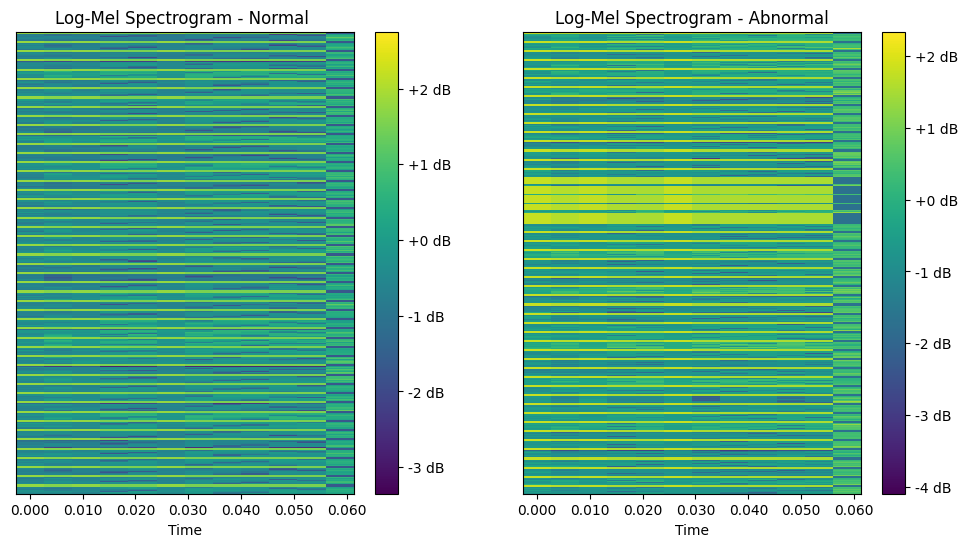

In [6]:
#Display the shape of the train_data and test_data after preprocessing
plt.figure(figsize=(12, 6))

sr=96000
plt.subplot(1, 2, 1)
librosa.display.specshow(X_train_selected[:, :int(5 * sr / 512)], x_axis='time', sr=sr, hop_length=512, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram - Normal ')

# Plot the second subplot with the initial part of test_data
plt.subplot(1, 2, 2)
librosa.display.specshow(X_test_selected[:, :int(5 * sr / 512)], x_axis='time', sr=sr, hop_length=512, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram - Abnormal')

plt.show()


In [20]:
# # Define the file path to SAVE PROCESSED DATA
# train_pickle = "./Project_Files/Dataset/train_no_pore_96khz_processed.pkl"
# test_pickle = "./Project_Files/Dataset/test_pore_96khz_processed.pkl"

# # Save the train_data as a pickle file
# with open(train_pickle, 'wb') as file:
#     pickle.dump(X_train_selected, file)
# with open(test_pickle, 'wb') as file:
#     pickle.dump(X_test_selected, file)


## Autoencoders in Anomaly Detection

Autoencoders are neural network architectures designed for unsupervised learning. They consist of an encoder and a decoder, which work collaboratively to learn a compressed representation of input data. In anomaly detection applications, such as the AKoS project, autoencoders excel at learning to reconstruct normal data accurately. The core principle lies in the ability to identify anomalies by detecting higher reconstruction errors when presented with abnormal data. This theoretical foundation serves as the basis for the subsequent sections detailing the implementation of autoencoders in the project.

### Model Training

The implementation of the autoencoder architecture using TensorFlow and Keras is explained theoretically in this section.
### Architecture

The autoencoder consists of three main components:

    Encoder: The encoder compresses the input data into a lower-dimensional representation, capturing the essential features associated with normal weld seams.

    Bottleneck: The bottleneck layer represents the most compact form of the input data. It serves as a bottleneck through which the essential information must pass.

    Decoder: The decoder reconstructs the input data from the compressed representation, aiming to closely match the original input.

### Training Process

The training process involves several key elements:

    Learning Rate: The Adam optimizer with a specified learning rate is used to minimize the mean squared error between the input and reconstructed output.

    Learning Rate Scheduler: A learning rate scheduler adjusts the learning rate during training to enhance convergence. In this case, the learning rate is reduced by 5% after each epoch.

    Early Stopping: Early stopping is employed to prevent overfitting. The training process is monitored for validation loss, and training is halted if no improvement is observed for a specified number of epochs.


## Training

In [ ]:
# # Train the autoencoder with data generator
# def learning_rate_scheduler(epoch, lr):

#     if epoch < 15:
#         return lr  # Keep the initial learning rate for the first 15 epochs
#     else:
#       return lr * tf.math.exp(-0.1)  # Decay the learning rate exponentially

# def data_generator(features, batch_size):
#     while True:
#         indices = np.random.choice(features.shape[0], size=batch_size, replace=False)
#         yield features[indices, :], features[indices, :]

# batch_size = 8

# model = models.Sequential([
#     tf.keras.layers.Input(shape=(X_train_selected.shape[1],)),      
#     tf.keras.layers.Dense(16, activation='relu'),  
#     tf.keras.layers.Dense(8, activation='relu'),  
#     tf.keras.layers.Dense(16, activation='relu'),  
#     tf.keras.layers.Dense(X_train_selected.shape[1], activation='sigmoid')
# ])
# X_train_data, X_val_data = train_test_split(X_train_selected, test_size=0.2, random_state=42)

# train_generator = data_generator(X_train_data, batch_size)
# val_generator = data_generator(X_val_data, batch_size)

# lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['accuracy'])
# history = model.fit(train_generator, epochs=30, steps_per_epoch=len(X_train_data)//batch_size, validation_data=val_generator, validation_steps=len(X_val_data)//batch_size,callbacks=[lr_scheduler])
# model.save('./Project_Files/Model/pore_classifier.h5')

Epoch 1/30
15345/15345 [==============================] - 147s 10ms/step - loss: 0.4794 - accuracy: 0.6624 - val_loss: 0.4417 - val_accuracy: 0.7092 - lr: 1.0000e-04
Epoch 2/30
15345/15345 [==============================] - 146s 10ms/step - loss: 0.4408 - accuracy: 0.7352 - val_loss: 0.4425 - val_accuracy: 0.9360 - lr: 1.0000e-04
Epoch 3/30
15345/15345 [==============================] - 147s 10ms/step - loss: 0.4404 - accuracy: 0.9173 - val_loss: 0.4416 - val_accuracy: 0.9405 - lr: 1.0000e-04
Epoch 4/30
15345/15345 [==============================] - 143s 9ms/step - loss: 0.4393 - accuracy: 0.9451 - val_loss: 0.4405 - val_accuracy: 0.9430 - lr: 1.0000e-04
Epoch 5/30
15345/15345 [==============================] - 143s 9ms/step - loss: 0.4410 - accuracy: 0.9477 - val_loss: 0.4352 - val_accuracy: 0.9473 - lr: 1.0000e-04
Epoch 6/30
15345/15345 [==============================] - 144s 9ms/step - loss: 0.4401 - accuracy: 0.9486 - val_loss: 0.4433 - val_accuracy: 0.9483 - lr: 1.0000e-04
Epoch 7

/home/shaxpy/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



## Evaluation and Testing

This section provides a theoretical framework for evaluating the trained autoencoder using both training and testing datasets. The primary metric used is the reconstruction error, which is subsequently utilized to determine a threshold for classifying samples as normal or abnormal.

### Reconstruction Errors

Reconstruction errors are calculated by comparing the input data with the reconstructed output from the autoencoder. The mean squared error serves as a measure of the dissimilarity between the original and reconstructed data. Higher reconstruction errors indicate potential anomalies in the acoustic signals.


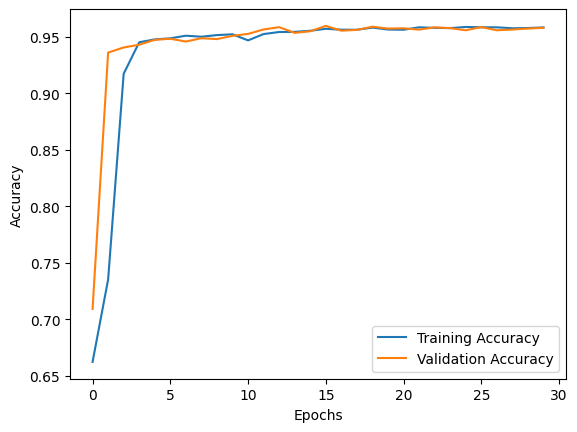

In [ ]:
# Plotting Accuracy and Loss
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot training and validation accuracy
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Model Summary
model = tf.keras.models.load_model('./Project_Files/Model/pore_classifier.h5')
print(model.summary())


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 16)                208       
                                                                 
 dense_41 (Dense)            (None, 8)                 136       
                                                                 
 dense_42 (Dense)            (None, 16)                144       
                                                                 
 dense_43 (Dense)            (None, 12)                204       
                                                                 
Total params: 692 (2.70 KB)
Trainable params: 692 (2.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None



## Results and Discussion

This section discusses the outcomes of the autoencoder-based anomaly detection model. It includes visualizations of log-mel spectrograms, providing a qualitative understanding of the model's performance. Additionally, a comparison of mean reconstruction errors for normal and abnormal samples is presented.

### Visualizations

Visualizations play a crucial role in understanding the model's performance. Log-mel spectrograms for normal and abnormal samples are visualized, allowing for a qualitative assessment of how well the autoencoder captures the essential features in acoustic signals.

### Mean Reconstruction Errors

A bar graph comparing the mean reconstruction errors for training and testing datasets provides quantitative insights into the model's performance. A lower mean reconstruction error for normal samples compared to abnormal samples indicates the model's effectiveness in distinguishing between the two.

## Model Testing on External Data

This section delves into the theoretical aspects of testing the model's robustness using external datasets representing normal and abnormal weld seams. The classification results from these external datasets showcase the model's ability to generalize beyond the training data, a critical factor in real-world applications.


## Testing on Original Samples
#### Train_Data : Wall_17_AL_io_20220614
#### Test_Data : Wall_23_AL_Oel_Zusatz_20220620

In [3]:
# Load Train and Test processed file
train_pickle = "./Project_Files/Dataset/train_no_pore_96khz_processed.pkl"
test_pickle = "./Project_Files/Dataset/test_pore_96khz_processed.pkl"

with open(train_pickle, 'rb') as file:
    train_data_process = pickle.load(file)
with open(test_pickle, 'rb') as file:
    test_data_process = pickle.load(file)

X_train_selected=train_data_process
X_test_selected=test_data_process
threshold=0.43866489608647974

In [ ]:
# Loading scaler and selector objects from pickle files

scaler_file_path = "./Project_Files/Model/scaler.pkl"
# Save the scaler object to a file

with open(scaler_file_path, 'rb') as file:
    scaler = pickle.load(file)
selector_file_path = "./Project_Files/Model/selector.pkl"

# Save the scaler object to a file
with open(selector_file_path, 'rb') as file:
    selector = pickle.load(file)

4892/4892 [==============================] - 11s 2ms/step
Number of instances where Non-Pore is high: 31705
Number of instances where Pores is high: 124814
The signal is; Pore


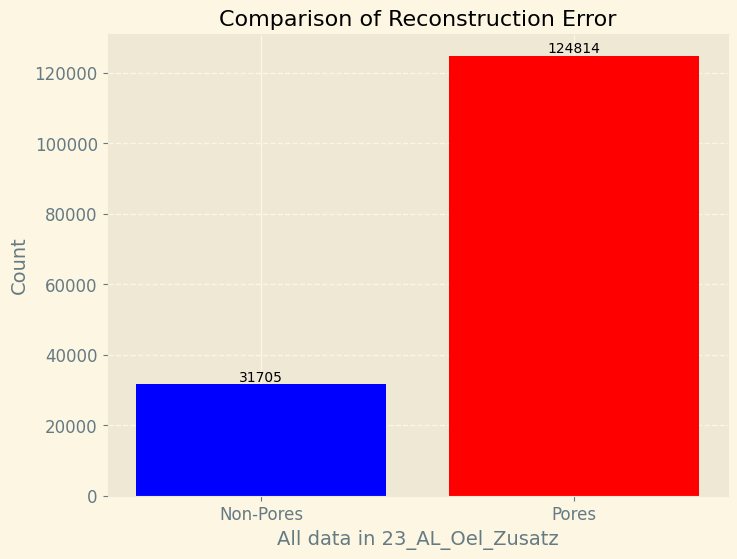

In [70]:
# Load the trained autoencoder model
model = tf.keras.models.load_model('./Project_Files/Model/pore_classifier.h5')

# Use the autoencoder to reconstruct the data
reconstructed_data = model.predict(X_train_selected)

# Calculate reconstruction errors
reconstruction_errors_train = np.mean(np.square(X_train_selected - reconstructed_data), axis=1)

reconstructed_data = model.predict(X_test_selected)

# Calculate reconstruction errors
reconstruction_errors_test = np.mean(np.square(X_test_selected - reconstructed_data), axis=1)

# Plot the reconstruction errors for train and test data

# Reshape arrays to have a common size for broadcasting
common_size = max(reconstruction_errors_train.size, reconstruction_errors_test.size)
reshaped_train = np.resize(reconstruction_errors_train, common_size)
reshaped_test = np.resize(reconstruction_errors_test, common_size)

# Element-wise comparison
comparison_result = np.greater(reshaped_train, reshaped_test)

# Check if both errors have the same values
if np.allclose(reshaped_train, reshaped_test):
    classification = "Non-Pore (Same Values)"
else:
    # Count the number of True values (where list1 has higher values)
    normal_value_count = np.sum(comparison_result)

    # Count the number of False values (where list2 has higher values)
    abnormal_value_count = len(comparison_result) - normal_value_count

    # Print the results
    print(f"Number of instances where Non-Pore is high: {normal_value_count}")
    print(f"Number of instances where Pores is high: {abnormal_value_count}")

    # Check for classification based on counts
    if normal_value_count < abnormal_value_count:
        classification = "Pore"
    else:
        classification = "Non-Pore"

# Print the final classification
print("The signal is; "+ classification)

# Plot the comparison result
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(['Non-Pores', 'Pores'], [normal_value_count, abnormal_value_count], color=['blue', 'red'])

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom', fontsize=10, color='black')

# Title and labels
plt.title('Comparison of Reconstruction Error', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('All data in 23_AL_Oel_Zusatz', fontsize=14)

# Style adjustments
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()

## Testing on 3 kinds of Samples: 
###  AL_Oel, GF50, and GF90

### Test1: Wall_12_AL_Oel_20220615

23/96 [======>.......................] - ETA: 0s

96/96 [==============================] - 0s 3ms/step
Number of instances where Non-Pore is high: 141
Number of instances where Pores is high: 2928
The signal is; Pore


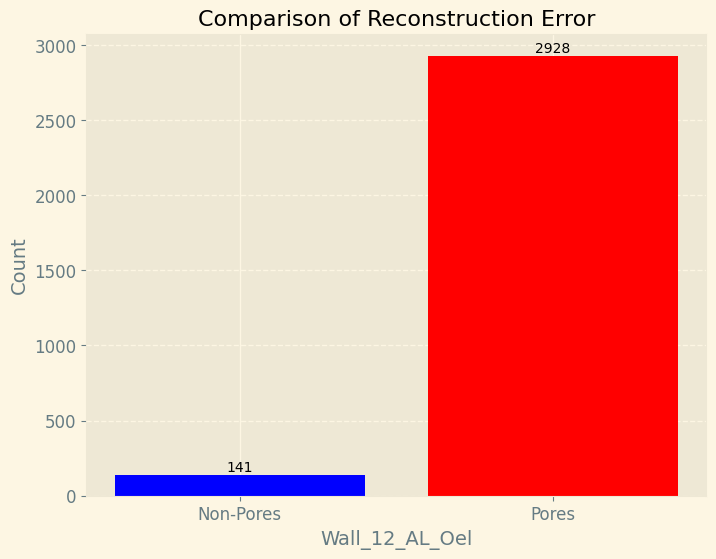

In [62]:
# # Loading AL_Oel_20220615 Data

test_file_path = "./Project_Files/test/test_oel.pkl"
normal_file_path = "./Project_Files/test/normal.pkl"

with open(test_file_path, 'rb') as file:
    X_test_selected_= pickle.load(file)

with open(normal_file_path, 'rb') as file:
    X_normal= pickle.load(file)
reconstructed_data = model.predict(X_test_selected_)

# Calculate reconstruction errors
reconstruction_errors_test = np.mean(np.square(X_test_selected_ - reconstructed_data), axis=1)


# Calculate reconstruction errors
reconstruction_errors_train = np.mean(np.square(X_normal - reconstructed_data), axis=1)

# Reshape arrays to have a common size for broadcasting
common_size = max(reconstruction_errors_train.size, reconstruction_errors_test.size)
reshaped_train = np.resize(reconstruction_errors_train, common_size)
reshaped_test = np.resize(reconstruction_errors_test, common_size)

# Element-wise comparison
comparison_result = np.greater(reshaped_train, reshaped_test)

# Check if both errors have the same values
if np.allclose(reshaped_train, reshaped_test):
    classification = "Non-Pore (Same Values)"
else:
    # Count the number of True values (where list1 has higher values)
    normal_value_count = np.sum(comparison_result)

    # Count the number of False values (where list2 has higher values)
    abnormal_value_count = len(comparison_result) - normal_value_count

    # Print the results
    print(f"Number of instances where Non-Pore is high: {normal_value_count}")
    print(f"Number of instances where Pores is high: {abnormal_value_count}")

    # Check for classification based on counts
    if normal_value_count < abnormal_value_count:
        classification = "Pore"
    else:
        classification = "Non-Pore"

# Print the final classification
print("The signal is; "+ classification)

# Plot the comparison result
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(['Non-Pores', 'Pores'], [normal_value_count, abnormal_value_count], color=['blue', 'red'])

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom', fontsize=10, color='black')

# Title and labels
plt.title('Comparison of Reconstruction Error', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Wall_12_AL_Oel', fontsize=14)

# Style adjustments
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()

### Test2: Wall_22_AL_GF50_20220615

25/96 [======>.......................] - ETA: 0s

96/96 [==============================] - 0s 2ms/step
Number of instances where Non-Pore is high: 52
Number of instances where Pores is high: 3017
The signal is; Pore


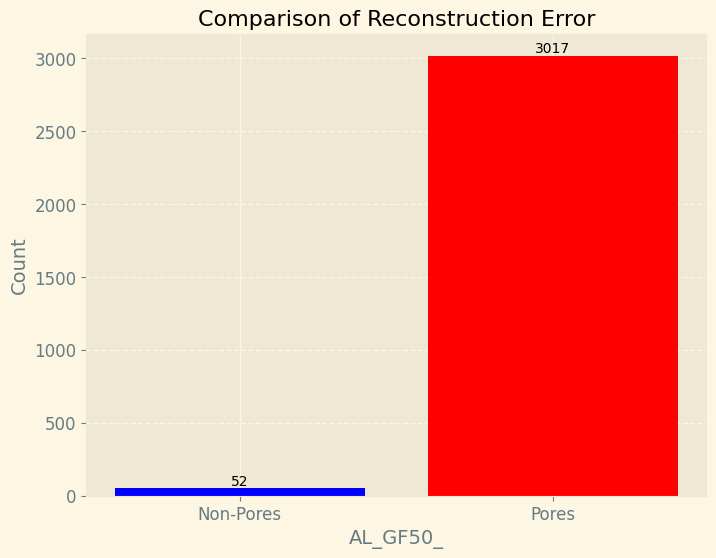

In [64]:
# # Loading AL_GF50 Data

test_file_path = "./Project_Files/test/test_GF50.pkl"

with open(test_file_path, 'rb') as file:
    X_test_selected_= pickle.load(file)
normal_file_path = "./Project_Files/test/normal.pkl"
with open(normal_file_path, 'rb') as file:
    X_normal= pickle.load(file)
#X_test_selected_ = X_test_selected_.reshape(-1,1)
reconstructed_data = model.predict(X_test_selected_)

# Calculate reconstruction errors
reconstruction_errors_test = np.mean(np.square(X_test_selected_ - reconstructed_data), axis=1)

# Use the autoencoder to reconstruct the data
reconstructed_data = model.predict(X_normal)

# Calculate reconstruction errors
reconstruction_errors_train = np.mean(np.square(X_normal - reconstructed_data), axis=1)

# Reshape arrays to have a common size for broadcasting
common_size = max(reconstruction_errors_train.size, reconstruction_errors_test.size)
reshaped_train = np.resize(reconstruction_errors_train, common_size)
reshaped_test = np.resize(reconstruction_errors_test, common_size)

# Element-wise comparison
comparison_result = np.greater(reshaped_train, reshaped_test)

# Check if both errors have the same values
if np.allclose(reshaped_train, reshaped_test):
    classification = "Non-Pore (Same Values)"
else:
    # Count the number of True values (where list1 has higher values)
    normal_value_count = np.sum(comparison_result)

    # Count the number of False values (where list2 has higher values)
    abnormal_value_count = len(comparison_result) - normal_value_count

    # Print the results
    print(f"Number of instances where Non-Pore is high: {normal_value_count}")
    print(f"Number of instances where Pores is high: {abnormal_value_count}")

    # Check for classification based on counts
    if normal_value_count < abnormal_value_count:
        classification = "Pore"
    else:
        classification = "Non-Pore"

# Print the final classification
print("The signal is; "+ classification)

# Plot the comparison result
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(['Non-Pores', 'Pores'], [normal_value_count, abnormal_value_count], color=['blue', 'red'])

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom', fontsize=10, color='black')

# Title and labels
plt.title('Comparison of Reconstruction Error', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('AL_GF50_', fontsize=14)

# Style adjustments
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()

### Test3: Wall_13_AL_GF90_20220614

72/96 [=====================>........] - ETA: 0s

96/96 [==============================] - 0s 2ms/step
Number of instances where Non-Pore is high: 140
Number of instances where Pores is high: 2929
The signal is; Pore


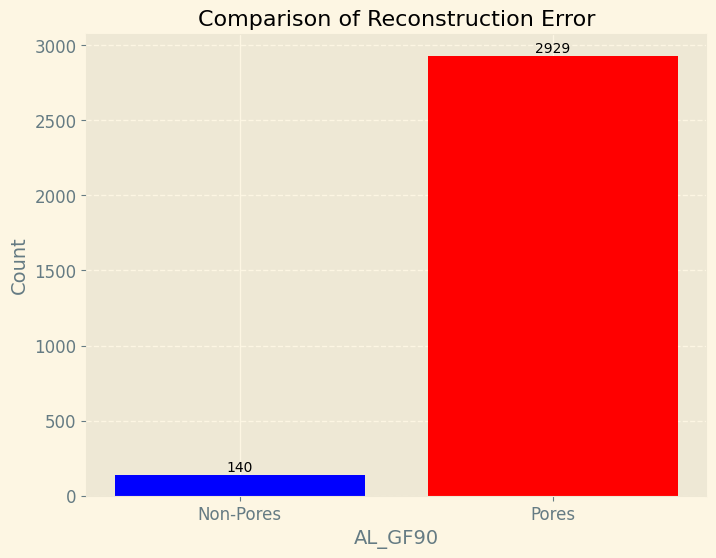

In [63]:
# Loading AL_GF90 Data

test_file_path = "./Project_Files/test/test_GF90.pkl"
with open(test_file_path, 'rb') as file:
    X_test_selected_= pickle.load(file)
normal_file_path = "./Project_Files/test/normal.pkl"
with open(normal_file_path, 'rb') as file:
    X_normal= pickle.load(file)
    
#X_test_selected_ = X_test_selected_.reshape(-1,1)
reconstructed_data = model.predict(X_test_selected_)

# Calculate reconstruction errors
reconstruction_errors_test = np.mean(np.square(X_test_selected_ - reconstructed_data), axis=1)

reconstructed_data = model.predict(X_normal)

# Calculate reconstruction errors
reconstruction_errors_train = np.mean(np.square(X_normal - reconstructed_data), axis=1)

# Reshape arrays to have a common size for broadcasting
common_size = max(reconstruction_errors_train.size, reconstruction_errors_test.size)
reshaped_train = np.resize(reconstruction_errors_train, common_size)
reshaped_test = np.resize(reconstruction_errors_test, common_size)

# Element-wise comparison
comparison_result = np.greater(reshaped_train, reshaped_test)

# Check if both errors have the same values
if np.allclose(reshaped_train, reshaped_test):
    classification = "Non-Pore (Same Values)"
else:
    # Count the number of True values (where list1 has higher values)
    normal_value_count = np.sum(comparison_result)

    # Count the number of False values (where list2 has higher values)
    abnormal_value_count = len(comparison_result) - normal_value_count

    # Print the results
    print(f"Number of instances where Non-Pore is high: {normal_value_count}")
    print(f"Number of instances where Pores is high: {abnormal_value_count}")

    # Check for classification based on counts
    if normal_value_count < abnormal_value_count:
        classification = "Pore"
    else:
        classification = "Non-Pore"

# Print the final classification
print("The signal is; "+ classification)

# Plot the comparison result
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(['Non-Pores', 'Pores'], [normal_value_count, abnormal_value_count], color=['blue', 'red'])

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom', fontsize=10, color='black')

# Title and labels
plt.title('Comparison of Reconstruction Error', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('AL_GF90', fontsize=14)

# Style adjustments
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()

### Code to test any file
##### Please run the preprocessing functions first (containing 'feature extraction' function)


In [ ]:
# # Loading any file

# # # Path to your file
# test_directory = "./Project_Files/Test_data/L01_10-06-48_io-pass/"
# normal_dir = "./Project_Files/normal/L08_09-59-44_io-pass/"

# testing_file= process_files(test_directory)
# normal_file= process_files(normal_dir)

# model = tf.keras.models.load_model('./Project_Files/Model/pore_classifier.h5')

# # Standardize the data after feature agglomeration
# X_test_scaled_ = scaler.transform(testing_file)

# # Transform the test data using the same selector
# X_test_selected_ = selector.transform(X_test_scaled_)
# #X_test_selected_ = X_test_selected_.reshape(-1,1)

# normal_file_path = "./Project_Files/test/normal.pkl"
# with open(normal_file_path, 'rb') as file:
#     X_normal= pickle.load(file)
    
# #X_test_selected_ = X_test_selected_.reshape(-1,1)
# reconstructed_data = model.predict(X_test_selected_)

# # Calculate reconstruction errors
# reconstruction_errors_test = np.mean(np.square(X_test_selected_ - reconstructed_data), axis=1)

# reconstructed_data = model.predict(X_normal)

# # Calculate reconstruction errors
# reconstruction_errors_train = np.mean(np.square(X_normal - reconstructed_data), axis=1)

# # Reshape arrays to have a common size for broadcasting
# common_size = max(reconstruction_errors_train.size, reconstruction_errors_test.size)
# reshaped_train = np.resize(reconstruction_errors_train, common_size)
# reshaped_test = np.resize(reconstruction_errors_test, common_size)

# # Element-wise comparison
# comparison_result = np.greater(reshaped_train, reshaped_test)

# # Check if both errors have the same values
# if np.allclose(reshaped_train, reshaped_test):
#     classification = "Non-Pore (Same Values)"
# else:
#     # Count the number of True values (where list1 has higher values)
#     normal_value_count = np.sum(comparison_result)

#     # Count the number of False values (where list2 has higher values)
#     abnormal_value_count = len(comparison_result) - normal_value_count

#     # Print the results
#     print(f"Number of instances where Non-Pore is high: {normal_value_count}")
#     print(f"Number of instances where Pores is high: {abnormal_value_count}")

#     # Check for classification based on counts
#     if normal_value_count < abnormal_value_count:
#         classification = "Pore"
#     else:
#         classification = "Non-Pore"

# # Print the final classification
# print("The signal is; "+ classification)

# # Plot the comparison result
# fig, ax = plt.subplots(figsize=(8, 6))
# bars = ax.bar(['Non-Pores', 'Pores'], [normal_value_count, abnormal_value_count], color=['blue', 'red'])

# # Add data labels on top of the bars
# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom', fontsize=10, color='black')

# # Title and labels
# plt.title('Comparison of Reconstruction Error', fontsize=16)
# plt.ylabel('Count', fontsize=14)

# # Style adjustments
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.grid(axis='y', linestyle='--')

# # Show the plot
# plt.show()



## Further Investigations

Despite the success demonstrated by the autoencoder, with accuracy of **95.83%** the report suggests avenues for further investigations. For example in different microphones other than  "**Microphone Gefell 1 = MK301, Amplification "32**" having different frequency than 96khz. Also, these include an extended analysis of pore distribution, exploration of audible cues from pores, and the application of existing techniques for pore recognition. These investigations aim to enhance the model's capabilities for a more comprehensive weld inspection.

## Conclusion

In conclusion, the Acoustic Weld Inspection Project introduces a novel approach to weld seam inspection. By leveraging autoencoders and advanced machine learning techniques, the project demonstrates the potential for significantly improving defect detection in safety-critical components. Ongoing research and investigations will contribute to refining the proposed approach and establishing it as a reliable tool for quality assurance in welding applications.This project, utilizing autoencoders, shows promising results for detecting defects in weld seams. The developed solution offers a reliable method for quality assurance in safety-critical components. Ongoing research and investigations will contribute to refining and enhancing the proposed approach for more robust weld inspection.

## References: 
These are the references and where we utilized them
1. https://github.com/aldente0630/sound-anomaly-detection-with-autoencoders/tree/main - 
    - We got the basic idea behind this anomaly detection from here. 
    - We also tried to understand their feature extraction also which was very helpful for the purpose of this project
    - The autoencoder architecture used by them was useful to figure out the right bottleneck layer

2. https://chat.openai.com/ - 
    - How to effectively improve accuracy when the data was overfitting and what strategies are possible to tune the hyperparameters
    - For drafting some parts of this report on Markdown and using proper scientific terms
3. 0_read_i32.py -
    - Original file used to read the audio signals, we referenced this to read the files needed to make our Normal data
4. Anomalous Sound Detection using unsupervised and semi-supervised autoencoders and gammatone audio representation - https://arxiv.org/abs/2006.15321 -
    - Understanding the architecture and how to build autoencoders for unsupervised learning
5. Deep Autoencoders for Acoustic Anomaly Detection: Experiments with Working Machine and In-Vehicle Audio - https://repositorium.sdum.uminho.pt/bitstream/1822/81433/1/aeaad2.pdf
    - Formulating the algorithm for using autoencoders in anomaly detection